In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
import matplotlib as mpl
import seaborn as sns

from matplotlib.animation import FuncAnimation
import os
import time
from scipy.stats import uniform
from scipy.integrate import quad
import tqdm as tqdm

from matplotlib import pyplot as plt
from matplotlib import colormaps
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Jaffe Density Profile

The Jaffe profile (or Jaffe model) is a mathematical function that is used to describe the distribution of mass or light in elliptical galaxies and the bulges of spiral galaxies. It was proposed by the astronomer Walter Jaffe in 1983. Its usefulness derives from the fact that it accurately reproduces a de Vaucouleurs profile when projected onto the sky.

The density in the Jaffe model is given by (see Binney and Treemaine):

$$
    \rho(r) = \frac{\rho_0 R_s^4}{r^2 (r + R_s)^2}.
$$

Where $R_s$ is the scale radius.

In order to generate such a distribution of particles we first have to compute the mass within a given radius $r$ as:

$$
    M(r) = \int_0^r \rho(r) 4 \pi r^2 dr = \dots = 4  \pi \rho_0 R_s^3 \frac{r}{r + R_s}.
$$

The total mass of the distribution is given by performing the limit from $0$ to $\infty$, so that

$$
    M = 4 \pi \rho_0 R_s^3 \longrightarrow \rho_0 = \frac{M}{4 \pi R_s^3}.
$$


Now we find the cumulative distribution function for the radii as

$$
    P(r) = \frac{M(r)}{M} = \frac{r}{r + R_s}.
$$

By inverting this last equation, we can find the inverse cumulative distribution funcion

$$
    r(P) = \frac{P R_s}{1 - P}
$$

The distribution function for $\theta$ and $\phi$ are the usual for spherically symmetric systems:

$$
    P(\phi) = \frac{1}{2 \pi},
$$
$$
    P(\theta) = \frac{1}{2} \left( 1 - \cos{\theta} \right).
$$

So that we simply have to generate a random $\phi$ between $0$ and $2 \pi$, while for $\theta$ we have to sample $P(\theta)$ from 0 to 1 and then extract $\theta$ as:

$$
    \theta = \arccos\left( 1 - 2P \right)
$$

In [2]:
N = 20000
M = 1
m = M/N
Rs = 1

rho_0 = M / (4 * np.pi * (Rs)**3)

## Density Profile

In [3]:
def Jaffe_profile(radii, Rs, rho_0):
    return (rho_0 * Rs**4)/(radii**2 * (radii+Rs)**2)

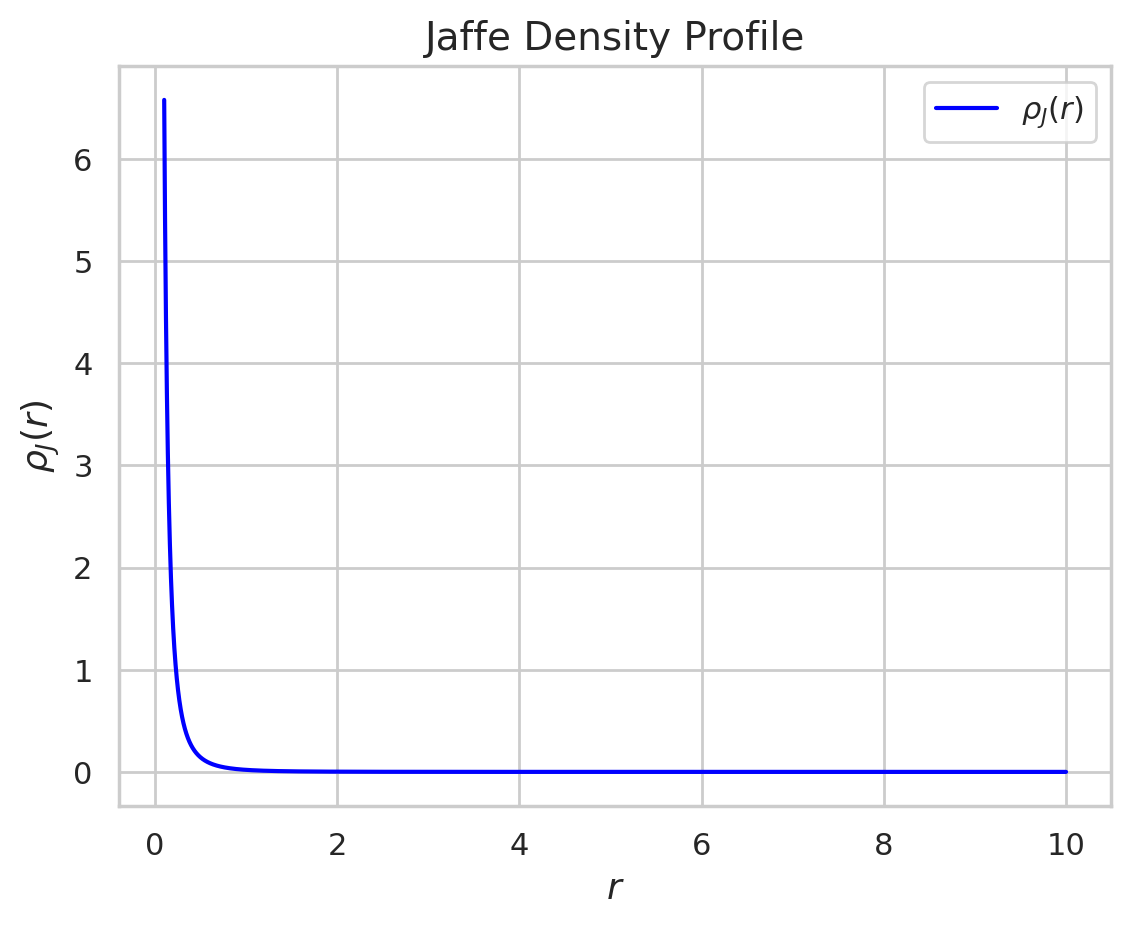

In [4]:
# Set Seaborn style
sns.set(style="whitegrid")

raggi = np.linspace(0.1, 10*Rs, N)
rho_J = Jaffe_profile(raggi, Rs, rho_0)

plt.plot(raggi, rho_J, color='blue', label=r'$\rho_J(r)$')
plt.title('Jaffe Density Profile', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\rho_J(r)$', fontsize=13)
plt.legend()


## Setting the coordinates

In [5]:
raggi = np.linspace(0.001, 30*Rs, 100)
P_r   = raggi / (raggi + Rs)

/home/ario/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ario/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ario/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ario/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

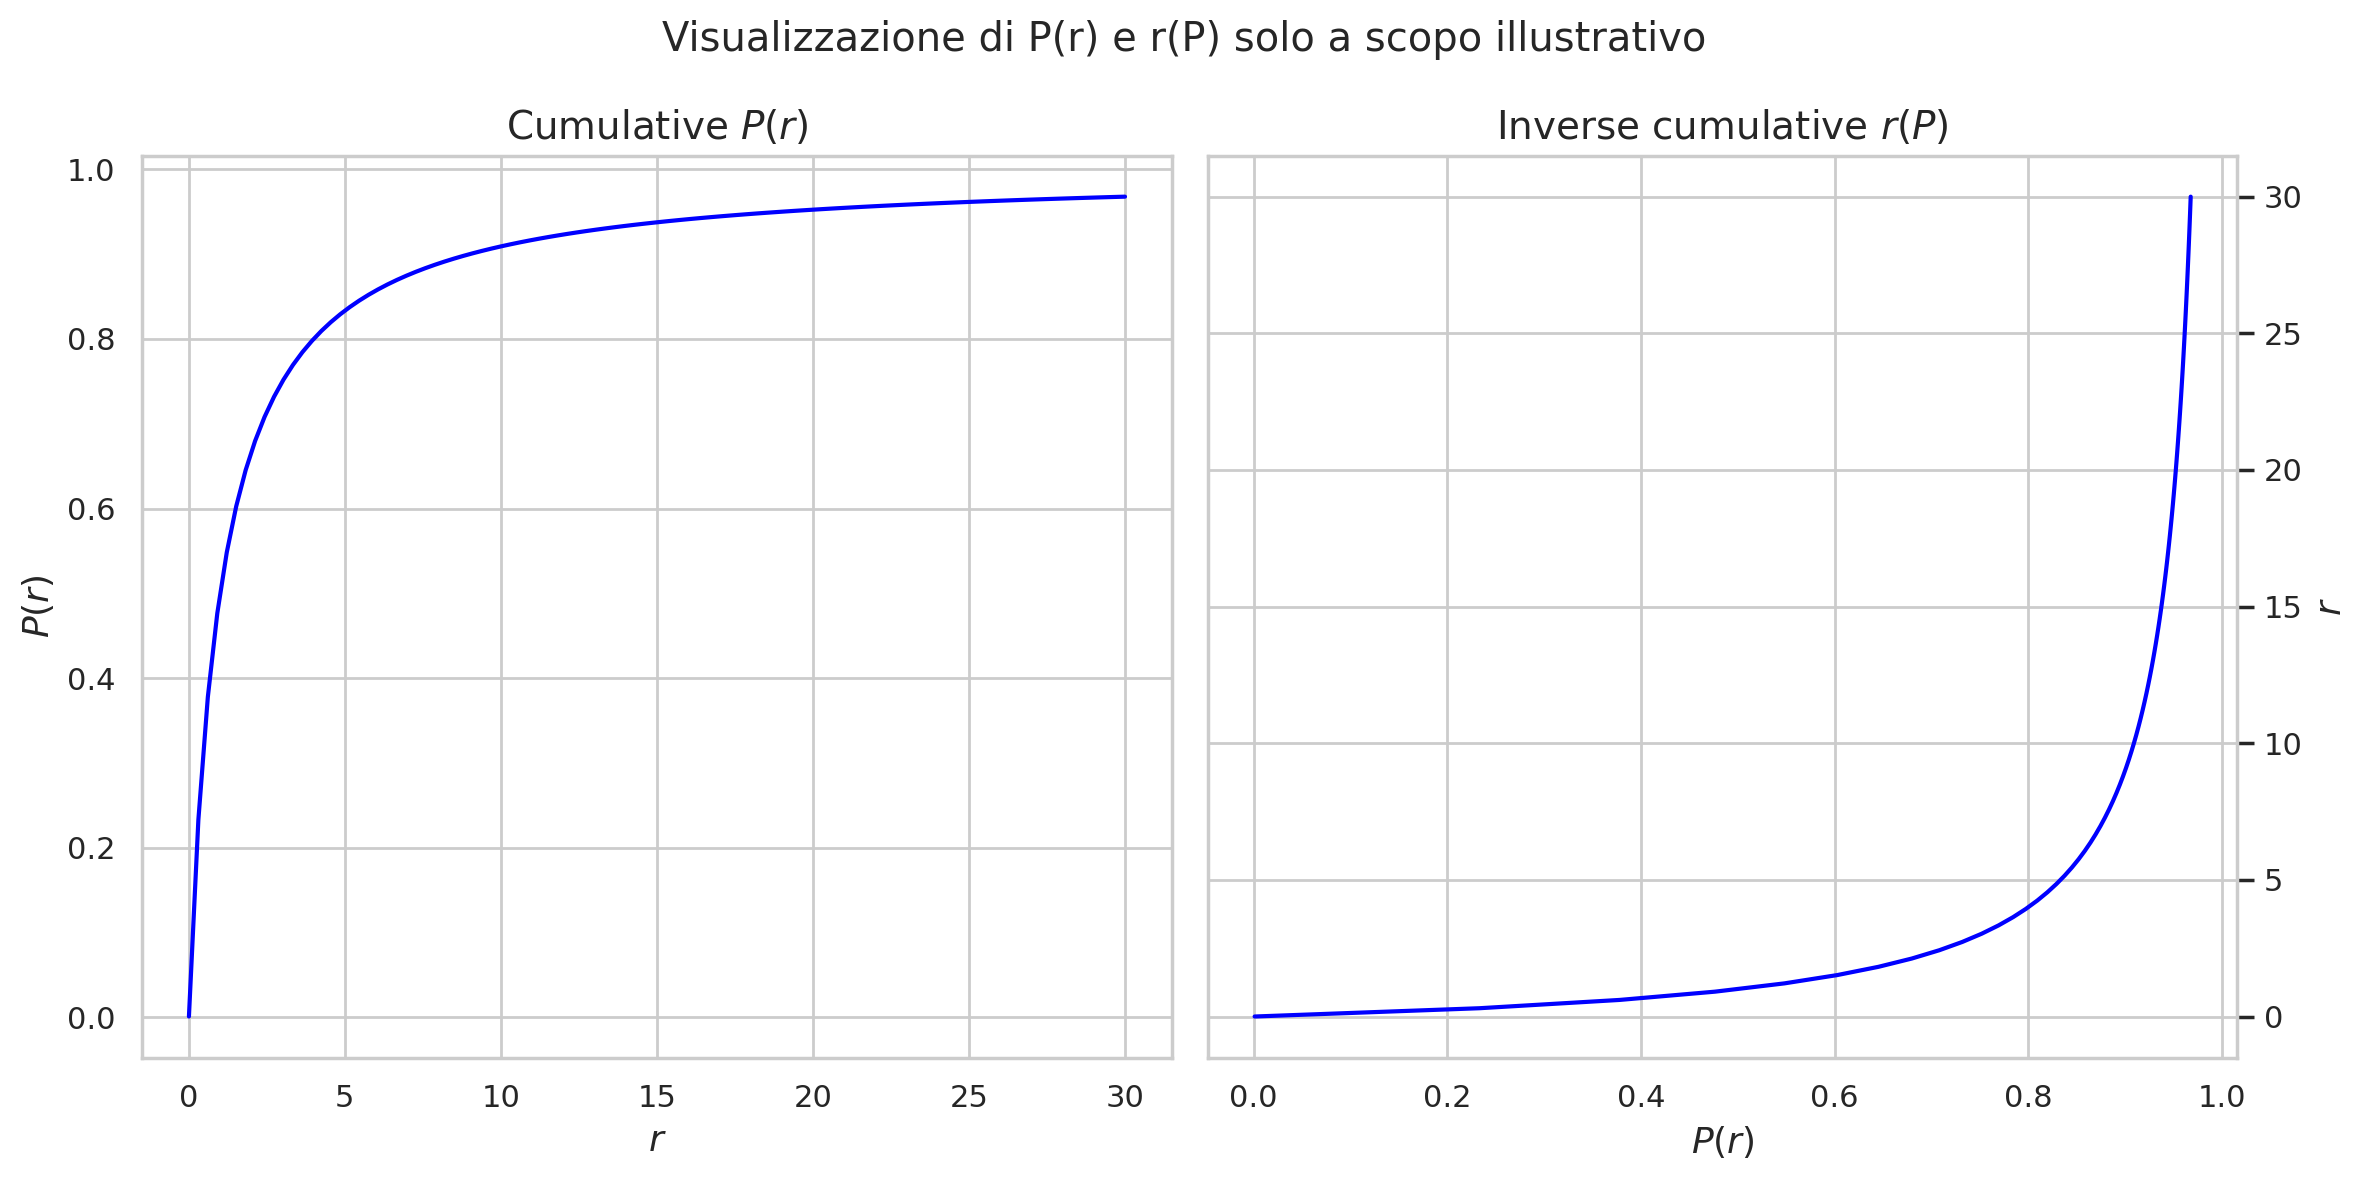

In [6]:
# Set Seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))

sns.lineplot(x=raggi, y=P_r, ax=ax[0], color='blue')
ax[0].set_title(r'Cumulative $P(r)$', fontsize=14)
ax[0].set_xlabel(r'$r$', fontsize=13)
ax[0].set_ylabel(r'$P(r)$', fontsize=13)

sns.lineplot(x=P_r, y=raggi, ax=ax[1], color='blue')
ax[1].set_title(r'Inverse cumulative $r(P)$', fontsize=14)
ax[1].set_xlabel(r'$P(r)$', fontsize=13)
ax[1].set_ylabel(r'$r$', fontsize=13)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)

# Common y-axis label
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

fig.suptitle('Visualizzazione di P(r) e r(P) solo a scopo illustrativo')

plt.show()

### Inverto la P(r)
Definisco una funzione che, estraendo un numero random tra 0 e 1 (P(r)), mi restituisce il rispettivo valore del raggio.

In [7]:
def find_radii(Rs, N):
    c = np.random.uniform(0, 1, size=N)
    return (c * Rs) / (1 - c)

## Qui definisco le coordinate dei punti che andrò a generare

In [8]:
# Raggi delle particelle
Rays = find_radii(Rs, N)

# Theta
cdf_theta = uniform.rvs(0, 1, size=N)  # cumulative function of thetas
thetas = np.arccos(1 - 2 * cdf_theta)

# Phi
phis = uniform.rvs(0, 2 * np.pi, size=N)

In [9]:
np.max(Rays), np.min(Rays)

(19404.73879206603, 3.643184187505231e-05)

In [10]:
from astropy.visualization.hist import hist as fancyhist

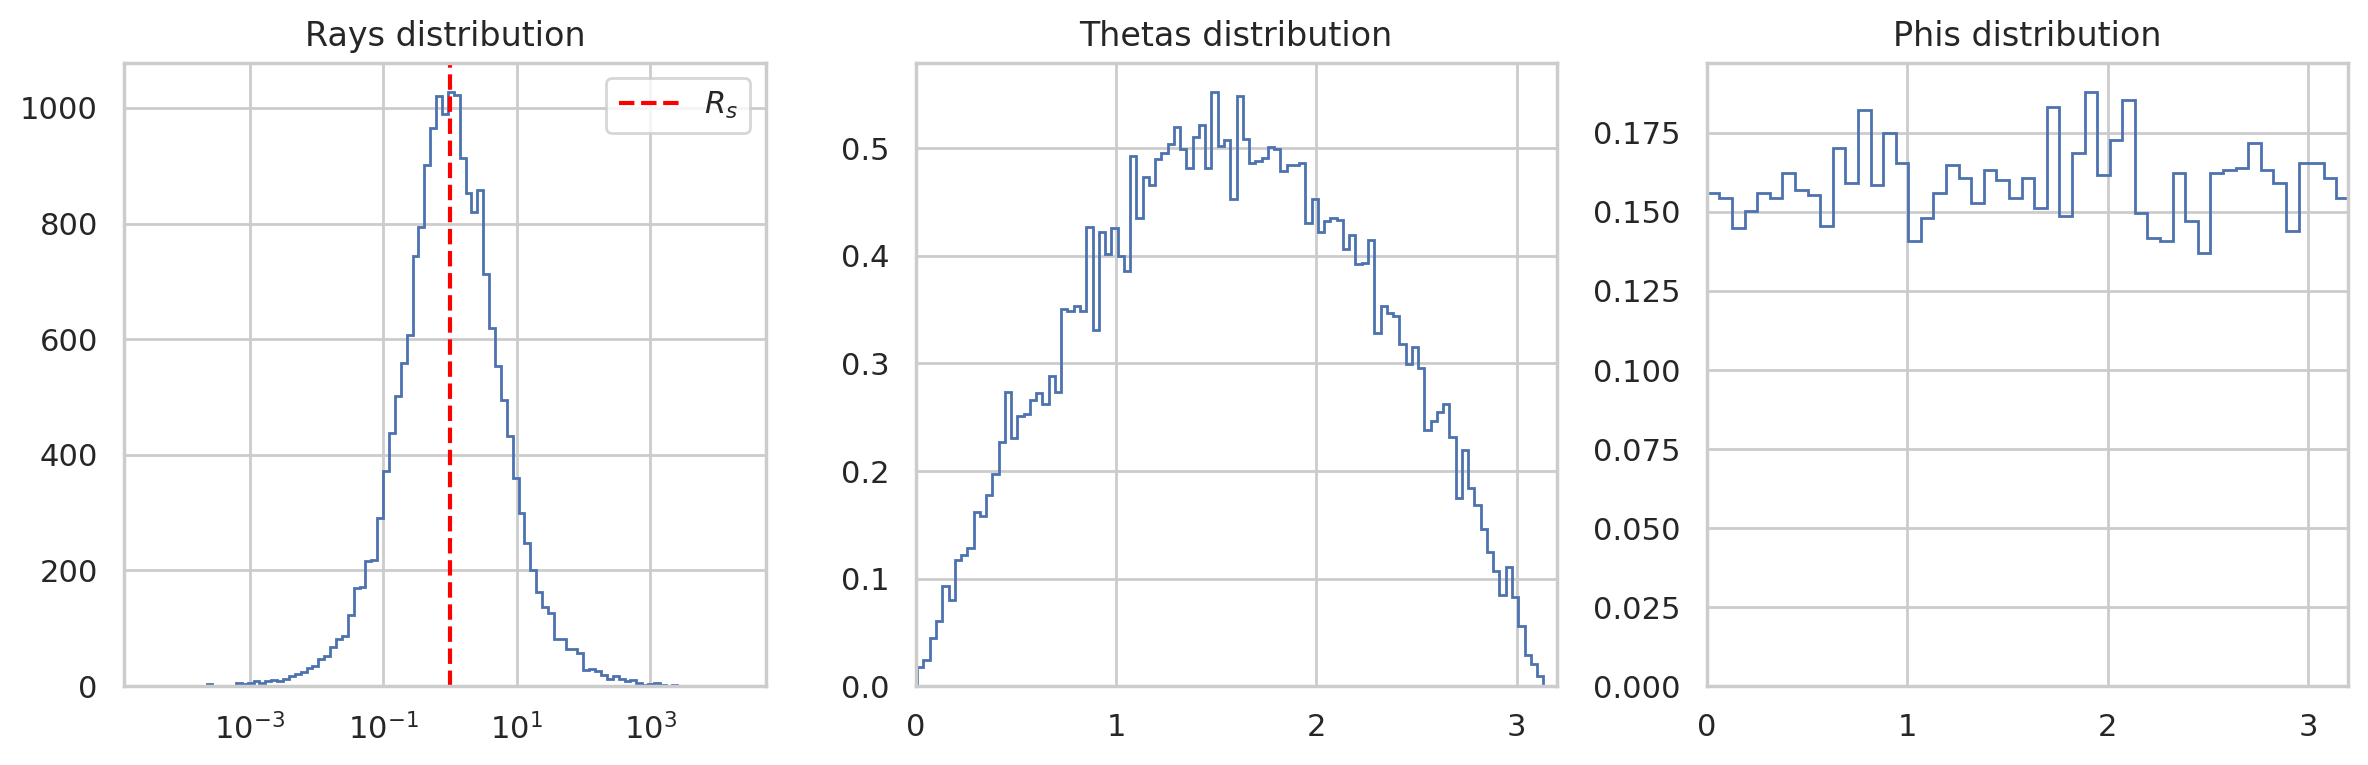

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(Rays, bins=np.logspace(np.log10(np.min(Rays)), np.log10(np.max(Rays)), 100), histtype='step')
axes[0].axvline(x=Rs, linestyle='--', color='red', label=r'$R_s$')
axes[0].set_title('Rays distribution')
axes[0].set_xscale('log')
axes[0].legend()

axes[1].hist(thetas, bins=100, density=True, histtype='step')
axes[1].set_title("Thetas distribution")
axes[1].set_xlim(0,3.2)

axes[2].hist(phis, bins=100, density=True, histtype='step')
axes[2].set_title("Phis distribution")
axes[2].set_xlim(0,3.2)

plt.tight_layout()

In [12]:
len([ray for ray in Rays if ray > 200*Rs])

100

In [13]:
# Calcolo il raggio entro il quale sta una certa percentuale di particelle
def calculate_radius(r, percentage):
    sorted_r = np.sort(r)
    index  = int(len(sorted_r)*percentage / 100)
    radius = sorted_r[index]

    return radius

In [14]:
percentage = 75
r_perc     = calculate_radius(Rays, percentage)

print(f'Il {percentage}% delle particelle si trova rinchiuso entro un raggio r = {r_perc}')

Il 75% delle particelle si trova rinchiuso entro un raggio r = 3.0637334353497434


Ora dalle coordinate sferiche passo alle coordinate cartesiane (X, Y, Z) con le solite trasformazioni.

In [15]:
X = Rays * np.sin(thetas) * np.cos(phis)
Y = Rays * np.sin(thetas) * np.sin(phis)
Z = Rays * np.cos(thetas)

In [16]:
print(np.min(np.abs(X)), np.max(X))

1.3953706706735004e-06 10820.46524248572


In [17]:
# Center  of Mass
x_cm = np.sum(M/N * X)/M
y_cm = np.sum(M/N * Y)/M
z_cm = np.sum(M/N * Z)/M
x_cm, y_cm, z_cm

(-0.1033491620607565, -0.25083686625509366, -0.7323529066058986)

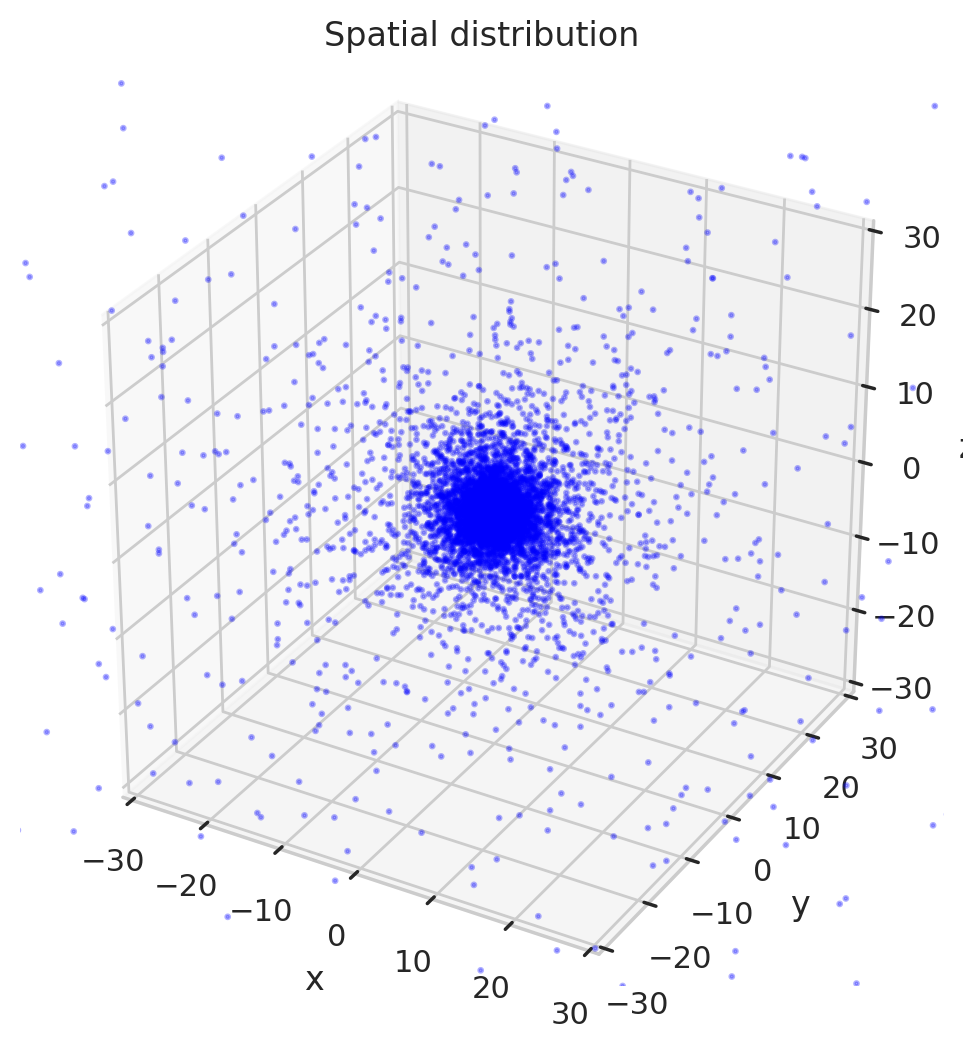

In [18]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z, c = 'blue', s=2, alpha = 0.3)
ax.set_box_aspect([1,1,1])
#ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(-30, 30)
ax.set_title("Spatial distribution")
ax.set_box_aspect([1,1,1])

plt.show();

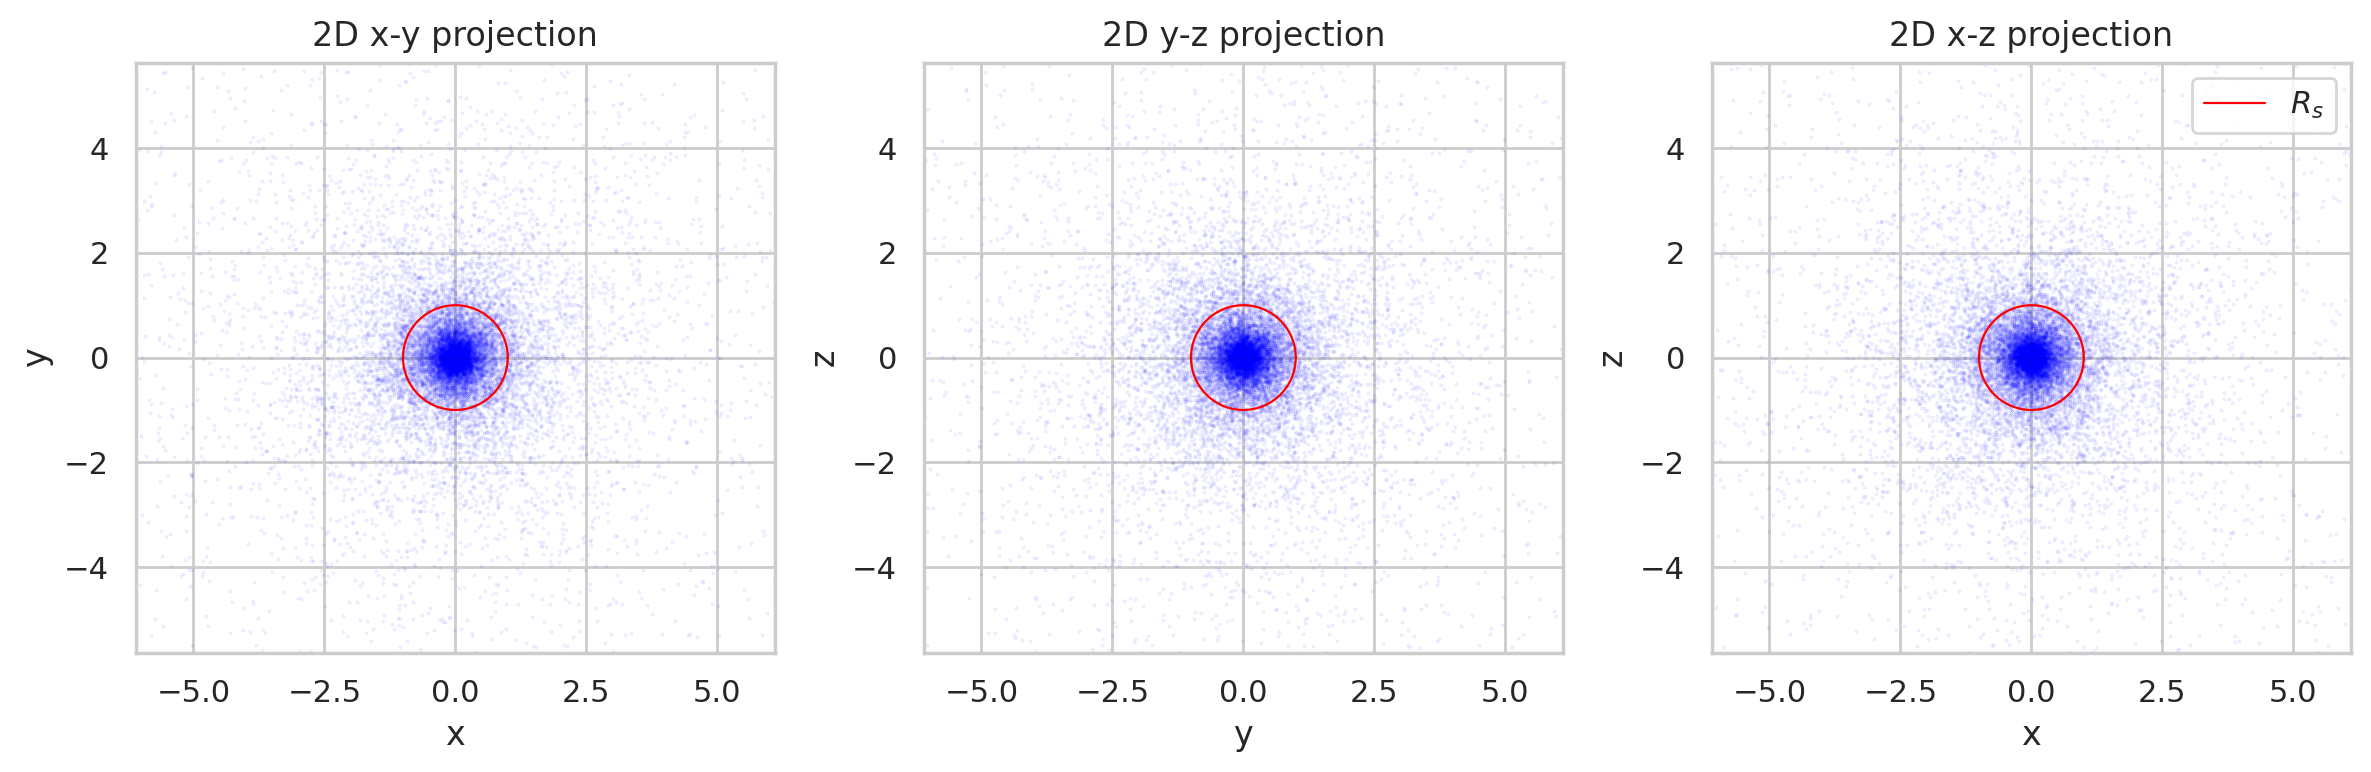

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Projection on x-y plane
theta = np.linspace(0, 2 * np.pi, 150)
a = Rs * np.cos( theta )
c = Rs * np.sin( theta )
axes[0].scatter(X, Y, c='blue', s=0.1, alpha=0.1)
axes[0].plot(a, c, c='red', linewidth=0.8, label=r'$R_s$')
axes[0].axis('equal')
axes[0].set_xlim(-5, 5)
axes[0].set_ylim(-5, 5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D x-y projection')

# Projection on y-z plane
axes[1].scatter(Y, Z, c='blue', s=0.1, alpha=0.1)
axes[1].plot(a, c, c='red', linewidth=0.8, label=r'$R_s$')
axes[1].axis('equal')
axes[1].set_xlim(-5, 5)
axes[1].set_ylim(-5, 5)
axes[1].set_xlabel('y')
axes[1].set_ylabel('z')
axes[1].set_title('2D y-z projection')


# Projection on x-z plane
axes[2].scatter(X, Z, c='blue', s=0.1, alpha=0.1)
axes[2].plot(a, c, c='red', linewidth=0.8, label=r'$R_s$')
axes[2].axis('equal')
axes[2].set_xlim(-5, 5)
axes[2].set_ylim(-5, 5)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
axes[2].set_title('2D x-z projection')

plt.legend()
plt.tight_layout()
plt.show()

# Check the density distribution

In [20]:
from tqdm import tqdm

In [21]:
np.min(Rays), np.max(Rays)

(3.643184187505231e-05, 19404.73879206603)

In [22]:
rays = np.linspace(np.min(Rays), 20*Rs, 100)
num_part = []
volumes = []

for i in range(1, len(rays)):
    count = sum(1 for r in Rays if r > rays[i-1] and r < rays[i])
    volumes.append(4/3 * np.pi * (rays[i]**3 - rays[i-1]**3))
    num_part.append(count)
    
num_part = np.array(num_part)
volumes = np.array(volumes)

rho = m * num_part / volumes

# Rimuovo il primo elemento da rays per fare il plot
rays = rays[1:]

theor_density_profile = Jaffe_profile(rays, Rs, rho_0)

Text(0.5, 1.0, 'Density Profile')

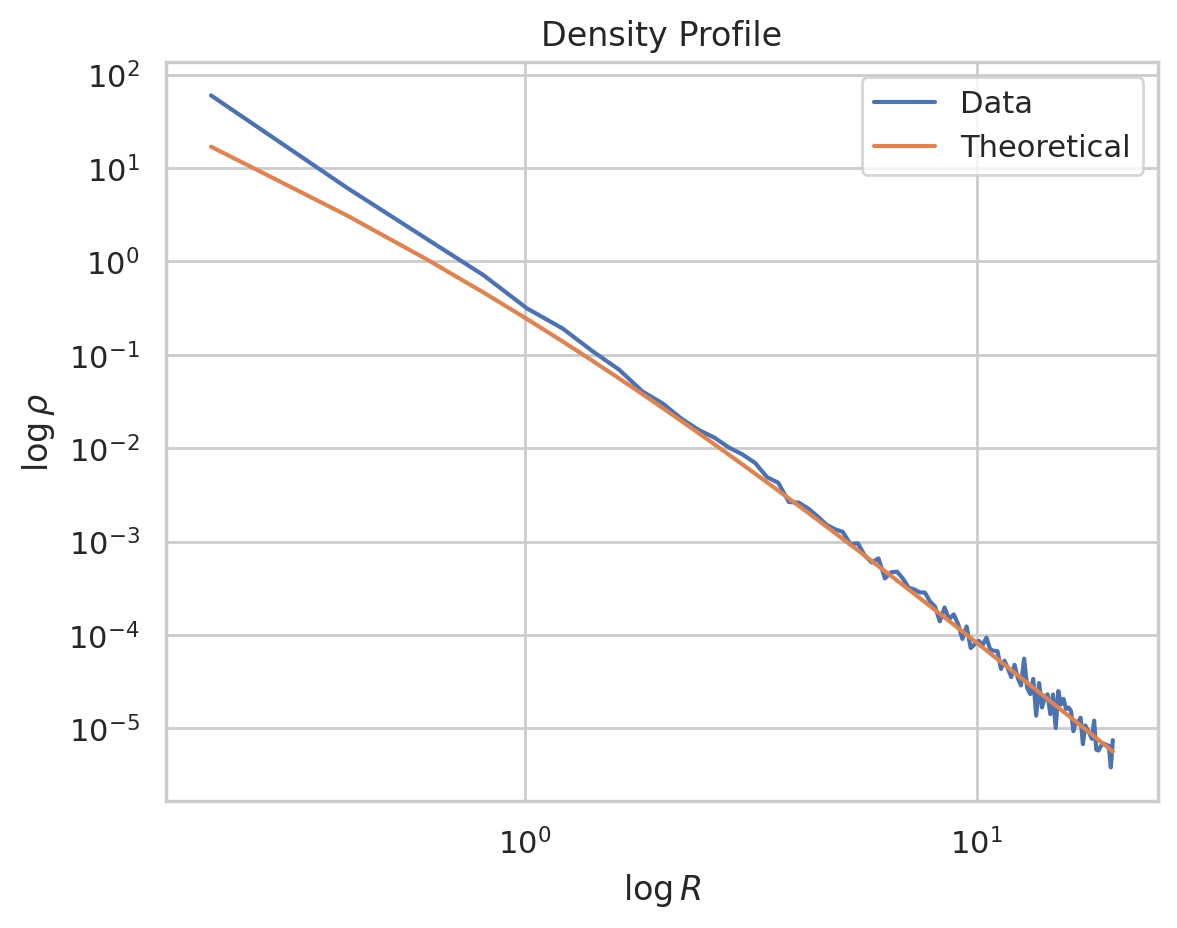

In [23]:
plt.loglog(rays, rho/rho_0, label='Data')
plt.loglog(rays, theor_density_profile/rho_0, label='Theoretical')
plt.legend()
#plt.xlim(1e-3, 1e2)
plt.xlabel(r'$\log{R}$')
plt.ylabel(r'$\log{\rho}$')
plt.title('Density Profile')

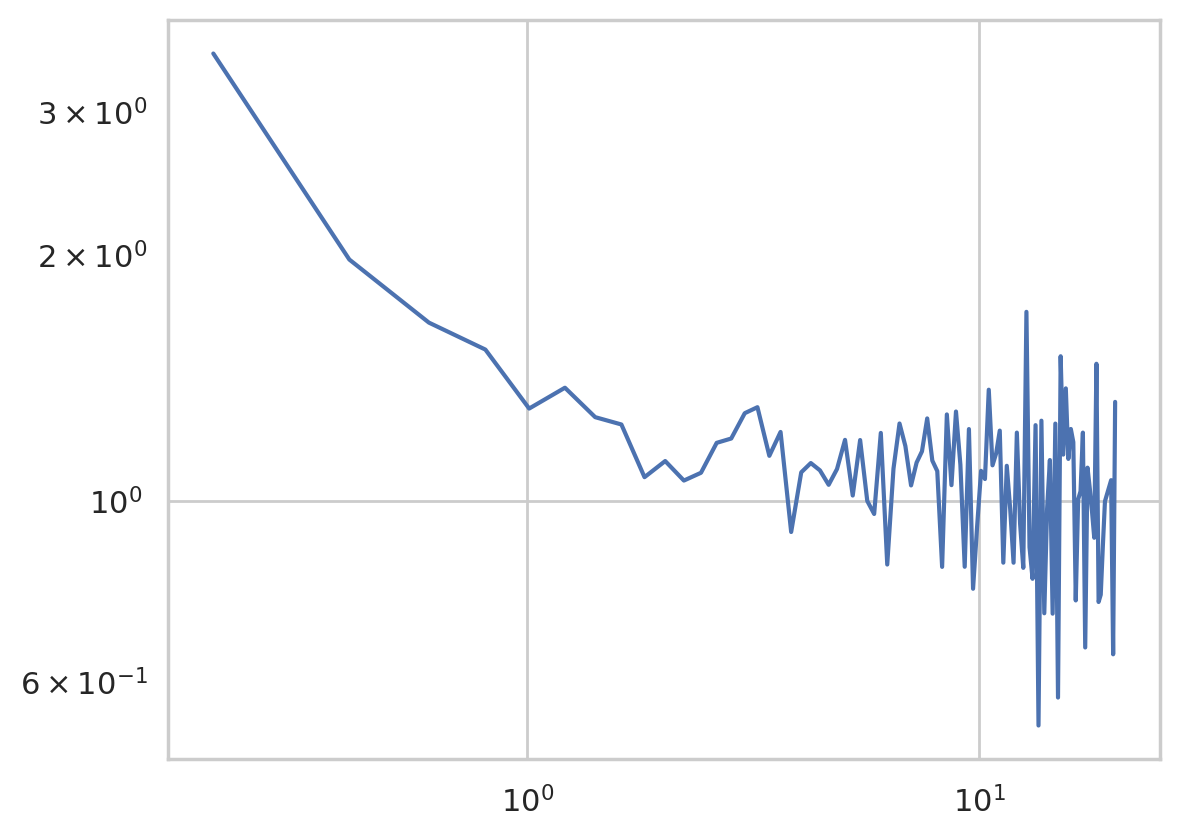

In [24]:
plt.loglog(rays, rho/theor_density_profile)

## Jaffe Potential

The potential can be computed via the following formula:

$$
    \Phi(r) =-4 \pi G \left[ \frac{1}{r} \int_0^r \frac{dr'}{(r'+ R_s)^2} + \int_r^\infty \frac{dr'}{r'(r' + R_s)^2}  \right] = \dots =  4 \pi G \rho_0 R_s^2 \ln{\left[ \frac{r}{r + R_s} \right]}
$$

In the Article i read:

$$
    \Psi(r) = \frac{G M}{R_s} \ln{\frac{r/R_s}{1 + r/R_s}}
$$

In [25]:
def Jaffe_pot(radii, Rs, rho_0):
    return 4 * np.pi * rho_0 * Rs**2 * np.log(radii/(radii+Rs))

In [26]:
Psi = Jaffe_pot(Rays, Rs, rho_0)   # Potenziale di ogni particella

### Visualizzazione del potenziale (solo a scopo illustrativo)

Qui io calcolo il potenziale gravitazionale 'a mano' per vedere se l'andamento rispecchia quello atteso per il potenziale di Jaffe!

In [27]:
def gravitational_potential(x, y, z, M_tot):
    num_particles = len(x)
    mass_per_particle = M_tot / num_particles
    potentials = np.empty(len(x))
    
    for i in tqdm(range(num_particles)):
        for j in range(num_particles):
            if i != j:
                distance = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)
                potential_ij = - mass_per_particle**2 / distance
                
                potentials[i] += potential_ij
    
    return potentials

In [28]:
Psi_data  = gravitational_potential(X, Y, Z, M)

100%|█████████████████████████████████████| 20000/20000 [07:35<00:00, 43.92it/s]


In [29]:
sorted_rays = np.sort(Rays)
j_pot = Jaffe_pot(sorted_rays, Rs, rho_0)
sort_Psi = np.sort(Psi_data)

In [30]:
np.where(Psi_data>1)

(array([], dtype=int64),)

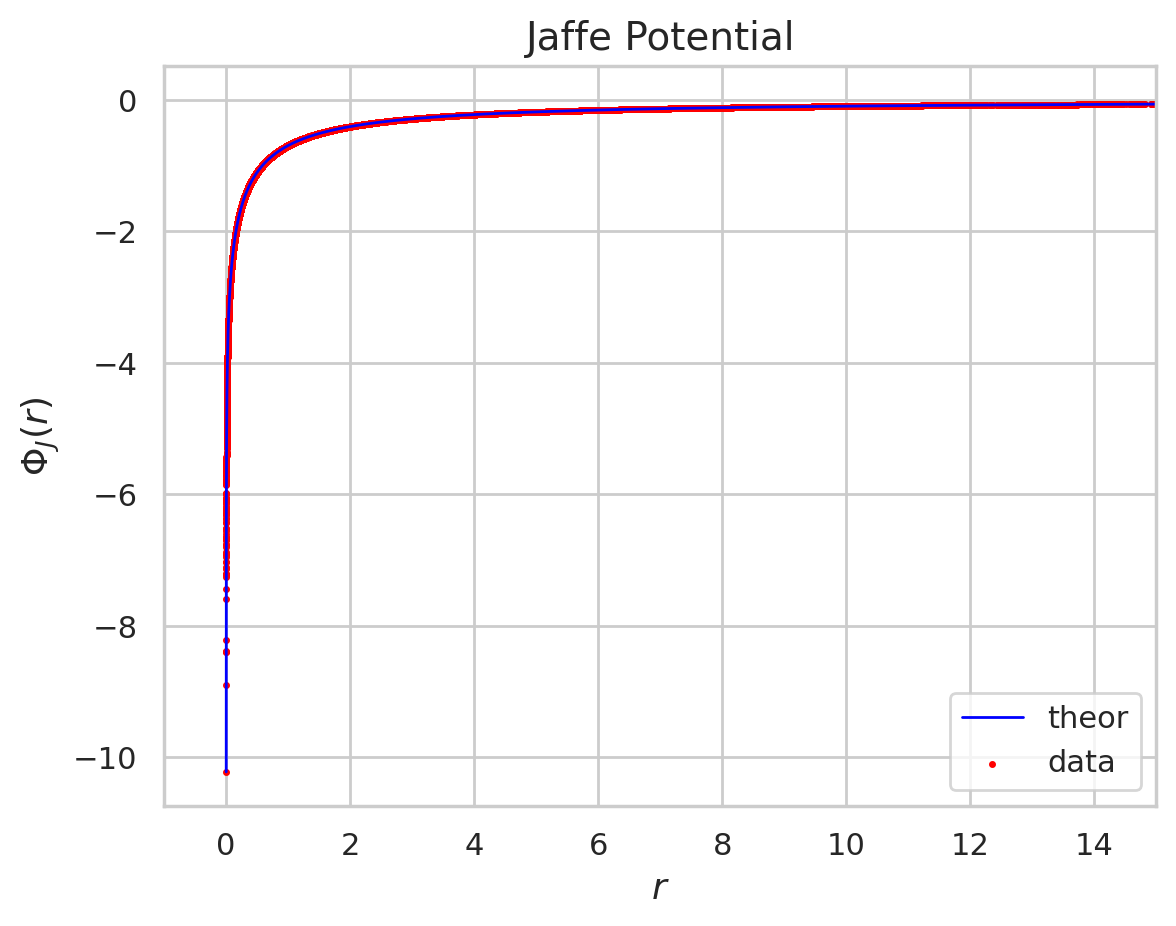

In [31]:
# Set Seaborn style
sns.set(style="whitegrid")
plt.plot(sorted_rays, j_pot, color='blue', label='theor', linewidth=1.0)
plt.scatter(sorted_rays, sort_Psi, color='red', marker='.', s=9,  label='data')
plt.title('Jaffe Potential', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.xlim(-0-1, 15)
plt.ylabel(r'$\Phi_J(r)$', fontsize=13)
plt.legend()

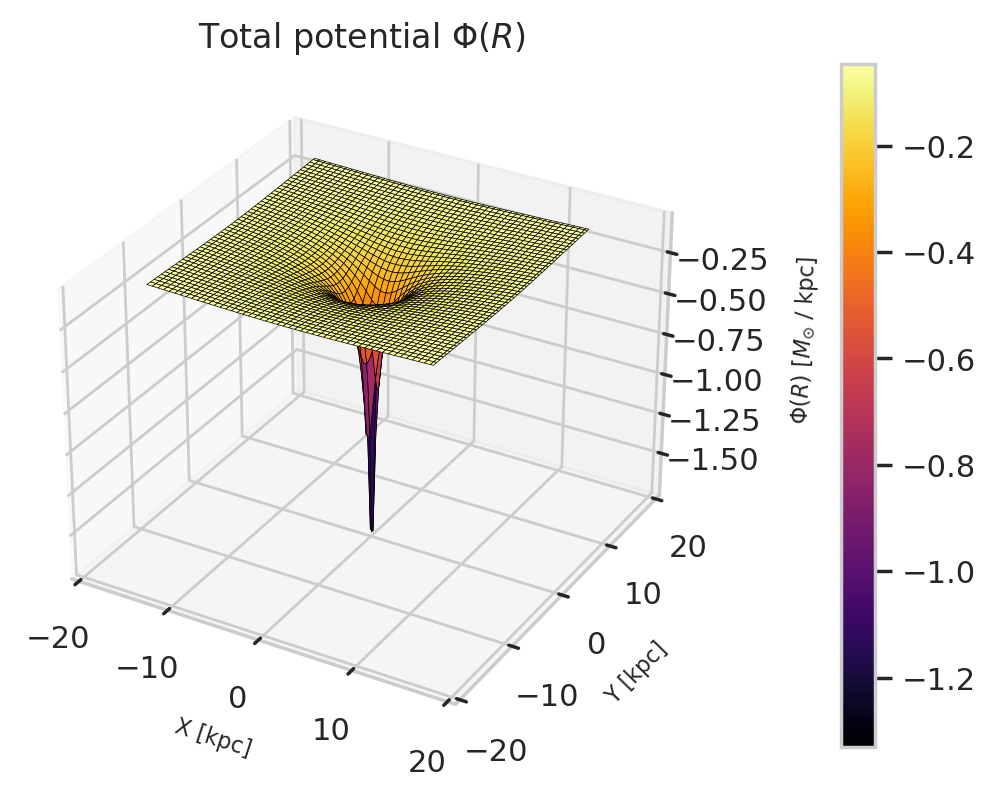

In [32]:
x_pot = np.linspace(-15 * Rs, 15 * Rs, 100)
y_pot = np.linspace(-15 * Rs, 15 * Rs, 100)

X_pot, Y_pot = np.meshgrid(x_pot, y_pot)
Psi_2d = Jaffe_pot(np.sqrt(X_pot**2+Y_pot**2), Rs, rho_0)

fig = plt.figure(figsize=(8, 4), tight_layout=True)
ax = fig.add_subplot(1, 1, 1, projection='3d')
image=ax.plot_surface(X_pot, Y_pot, Psi_2d, cmap='inferno', edgecolor='black', lw=0.25)
ax.set_xlabel('X [kpc]', fontsize=8)
ax.set_ylabel('Y [kpc]', fontsize=8)
ax.set_zlabel('\n\n $\Phi(R)$ [$M_{\odot}$ / kpc]', fontsize=8)
ax.set_title(r'Total potential $\Phi(R)$', fontsize=12)
ax.set_xlim(-20 * Rs, 20 * Rs)
ax.set_ylim(-20 * Rs, 20 * Rs)
ax.set_zlim(np.min(Psi_2d), np.max(Psi_2d))
#ax.view_init(35, -75)
plt.tight_layout()
plt.colorbar(image, fraction=0.046, pad=0.09)
#plt.savefig('Total-pot.pdf', bbox_inches='tight');
plt.show()

## Distribution Function
The DF for a Jaffe distribution is (see p 291 Binney):

$$
    f_J = \frac{1}{2 \pi^3 (G M R_s)^{3/2}} \left[ F_-(\sqrt{2\varepsilon}) - \sqrt{2}F_-(\sqrt{\varepsilon}) - \sqrt{2}F_+(\sqrt{\varepsilon}) +  F_+(\sqrt{2\varepsilon})\right]
$$

where $\varepsilon = - \frac{E R_s}{GM}$ and $F_\pm (x)$ is Dawson's integral, defined as:

$$
    F_\pm (x) \equiv e^{\mp x^2} \int_0^x dy e^{\pm y^2}.
$$



Siccome $R_s$, $G$, ed $M$ sono tutti settati a 1, posso scrivere che:

$$
    E = \frac{1}{2} v^2 + \Psi = - \varepsilon
$$

Posso scrivere la velocità di fuga $v_{esc}$ mettendo a $0$ l'energia:

$$
    v_{esc} = \sqrt{- 2 \Psi}
$$

e di conseguenza, posso scrivere $\varepsilon$ come:

$$
        \varepsilon = -\Psi \left[ 1 - \left( \frac{v}{v_{esc}} \right)^2  \right]
$$

e definendo $q = \frac{v}{v_{esc}}$

$$
    \varepsilon = - \Psi(1 - q^2)
$$

In [33]:
from scipy import special
from scipy.special import dawsn
from scipy.special import erf, erfi
import scipy.integrate as integrate

In [34]:
def integral(integrand, min, max):
    return integrate.quad(integrand, min, max)

In [35]:
def dawson_integral_positive(x):
    integrand = lambda t: np.exp(t**2)
    result, _ = integrate.quad(integrand, 0, x)
    return np.exp(-x**2) * result
    
def dawson_integral_negative(x):
    integrand = lambda t: np.exp(-t**2)
    result, _ = integrate.quad(integrand, 0, x)
    return np.exp(x**2) * result

### DF in funzione di $\varepsilon$

In [36]:
def df_jaffe(E, Rs, M):
    epsilon = (E*Rs)/M

    term1 = dawson_integral_negative(np.sqrt(2*epsilon))
    term2 = dawson_integral_negative(np.sqrt(epsilon))
    term3 = dawson_integral_positive(np.sqrt(epsilon))
    term4 = dawson_integral_positive(np.sqrt(2*epsilon))
    
    return (1 / (2* np.pi**3 * (M*Rs)**(3/2))) * (term1 - np.sqrt(2)*term2 - np.sqrt(2)*term3 + term4)

### DF in funzione di $q$

In [37]:
def Jaffe_DF(q, Psi, Rs, M):
    
    epsilon = -Psi * (1-q**2)
    
    term1 = dawson_integral_negative(np.sqrt(2*epsilon))
    term2 = dawson_integral_negative(np.sqrt(epsilon))
    term3 = dawson_integral_positive(np.sqrt(epsilon))
    term4 = dawson_integral_positive(np.sqrt(2*epsilon))
    
    df = (1 / (2* np.pi**3 * (M*Rs)**(3/2))) * (term1 - np.sqrt(2)*term2 - np.sqrt(2)*term3 + term4)
    
    return df       
    

## Visualizziamo $DF_J$ a  scopo illustrativo per vedere se rispecchia quella riportata sul libro

Text(0, 0.5, '$\\log{(GMa)^{3/2} f(\\varepsilon))}$')

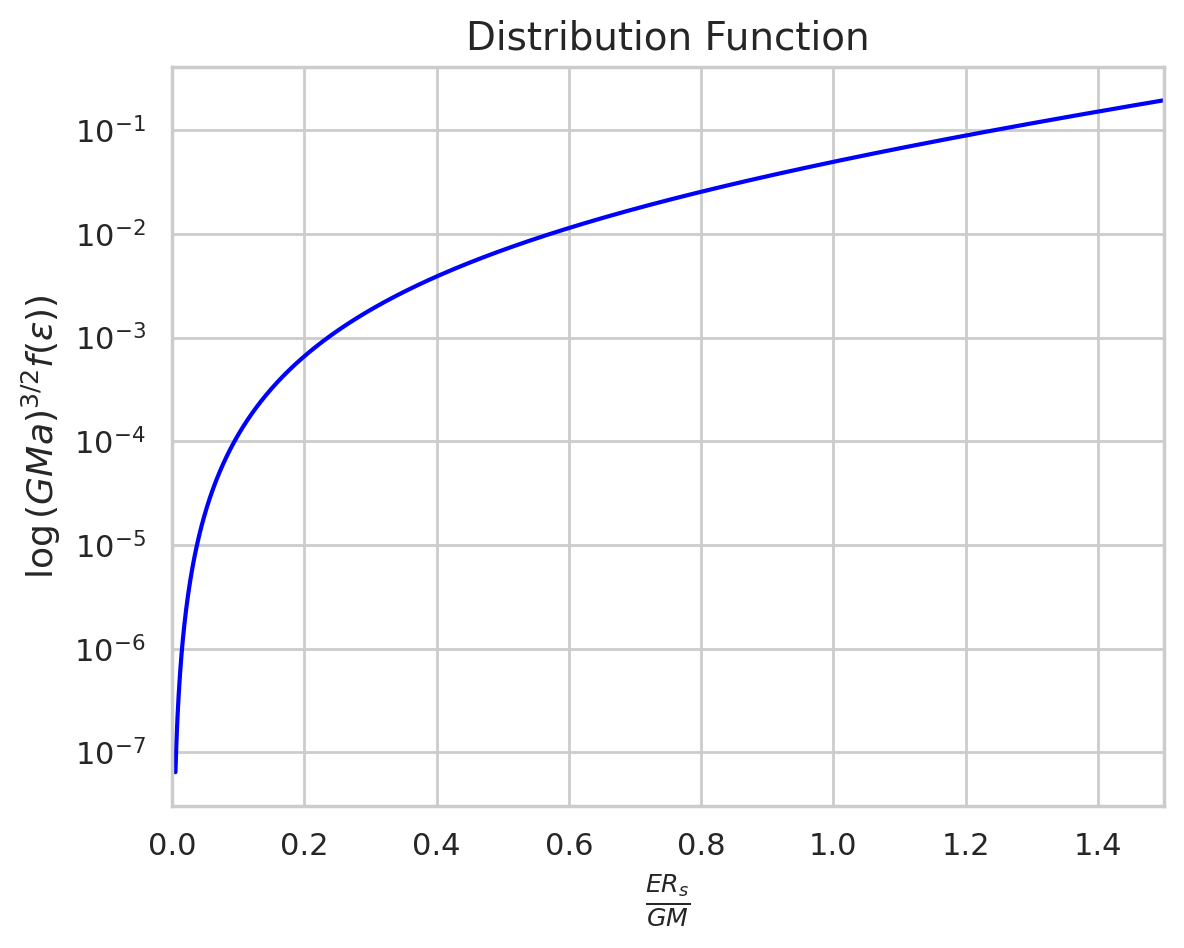

In [38]:
asse_x = np.linspace(0.005, 1.5, 10000)
df  = np.empty(len(asse_x))
# df1 = np.empty(len(asse_x))

E  = asse_x * M / Rs

for i in range(len(asse_x)):
    df[i] = df_jaffe(E[i], Rs, M)
    # df1[i] = df_jaffe2(E[i], Rs, M)

asse_y = (M*Rs)**(3/2) * df
# asse_y1 = (M*Rs)**(3/2) * df1


sns.set(style='whitegrid')

plt.semilogy(asse_x, asse_y, color='blue')
plt.xlim(0, 1.5)
plt.title(r'Distribution Function', fontsize=14)
plt.xlabel(r'$\frac{ER_s}{GM}$', fontsize=13)
plt.ylabel(r'$\log{(GMa)^{3/2} f(\varepsilon))}$', fontsize=13)

### $F(q)$

Dal fatto che, a un determinato valore del potenziale:

$$
    F(\varepsilon) = \int_0^{v_{esc}} f_J (\varepsilon) 4 \pi v^2 dv
$$

possimo fare un cambio di variabile $v \rightarrow q$ e scrivere $F$ come:

$$
    F(q) =  \int_0^1 f\left(-\Psi (1-q^2)\right) 4 \pi (- 2 \Psi q^2) \sqrt{- 2 \Psi} dq
$$

Quindi adesso definisco la funzione F dato un valore del potenziale.

In [39]:
def F(DF, q, psi):
    return DF * 4 * np.pi * (- 2 * psi * q**2) * np.sqrt(- 2 * psi)

In [40]:
from tqdm import tqdm

## MC rejection

Applico il metodo MonteCarlo estraendo un valore di q tra 0 e 1:

In [41]:
np.min(Psi), np.min(Psi_data)

(-10.220103820106903, -10.220507548701045)

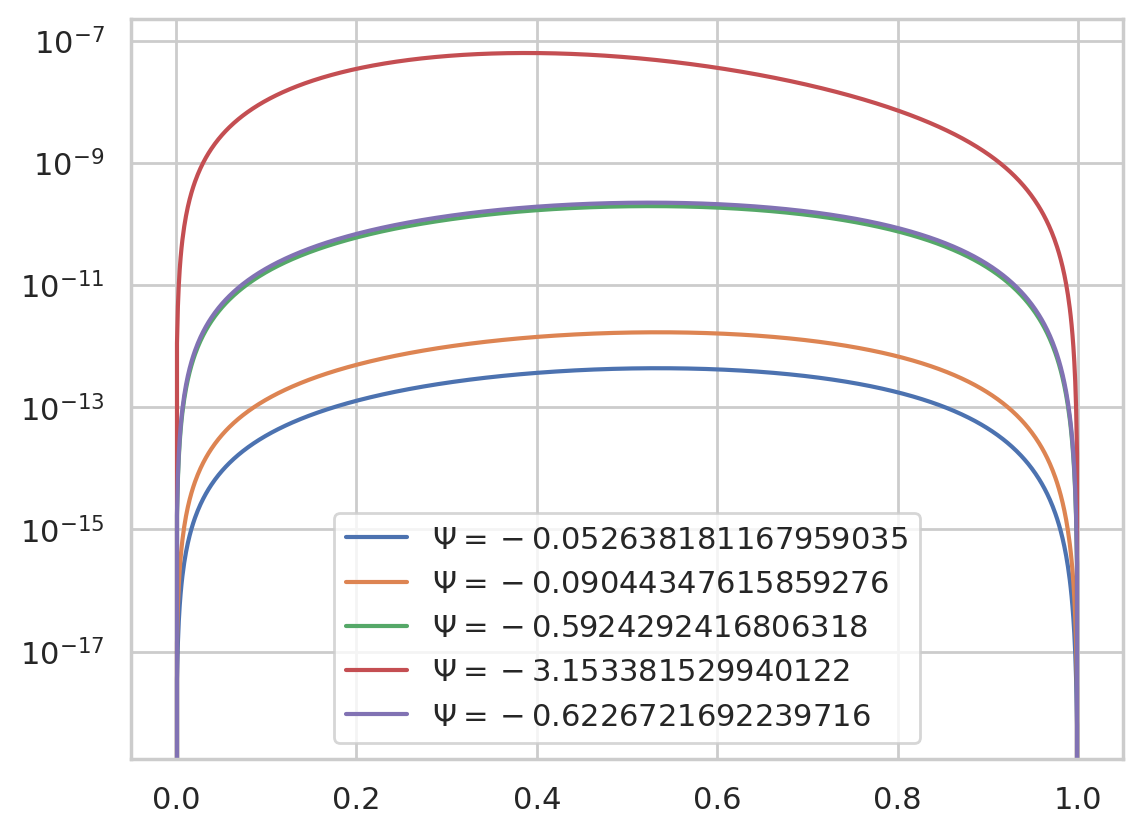

In [42]:
q_teo = np.linspace(0, 1, 1000)

for j in [0, 9, 99, 999, 9999]:
    F_teo = []
    for i in range(len(q_teo)):
        F_teo.append(F(Jaffe_DF(q_teo[i], Psi[j], Rs, M), q_teo[i], Psi_data[0]))

    plt.semilogy(q_teo, F_teo, label=fr'$\Psi = {Psi[j]}$')
    
plt.legend()

In [43]:
qs = []

for psi in tqdm(Psi):
    q = random.uniform(0,1)
    currentF = F(Jaffe_DF(q, psi, Rs, M), q, psi)
    max_F = np.max(currentF)
    
    y_rand = random.uniform(0, max_F)
    
    while(y_rand > F(Jaffe_DF(q, psi, Rs, M), q, psi)):
        q = random.uniform(0, 1)
          
        currentF = F(Jaffe_DF(q, psi, Rs, M), q, psi)
        max_F = np.max(currentF)
    
        y_rand = random.uniform(0, max_F)
    qs.append(q)
          
qs = np.array(qs)

100%|███████████████████████████████████| 20000/20000 [00:02<00:00, 9224.82it/s]


In [44]:
qs

array([0.62778366, 0.88376043, 0.46703737, ..., 0.18193047, 0.07997486,
       0.21066675])

In [45]:
velocities = qs * np.sqrt(-2*Psi)
velocities = velocities / 1.15

Text(0.5, 1.0, 'Velocities distribution')

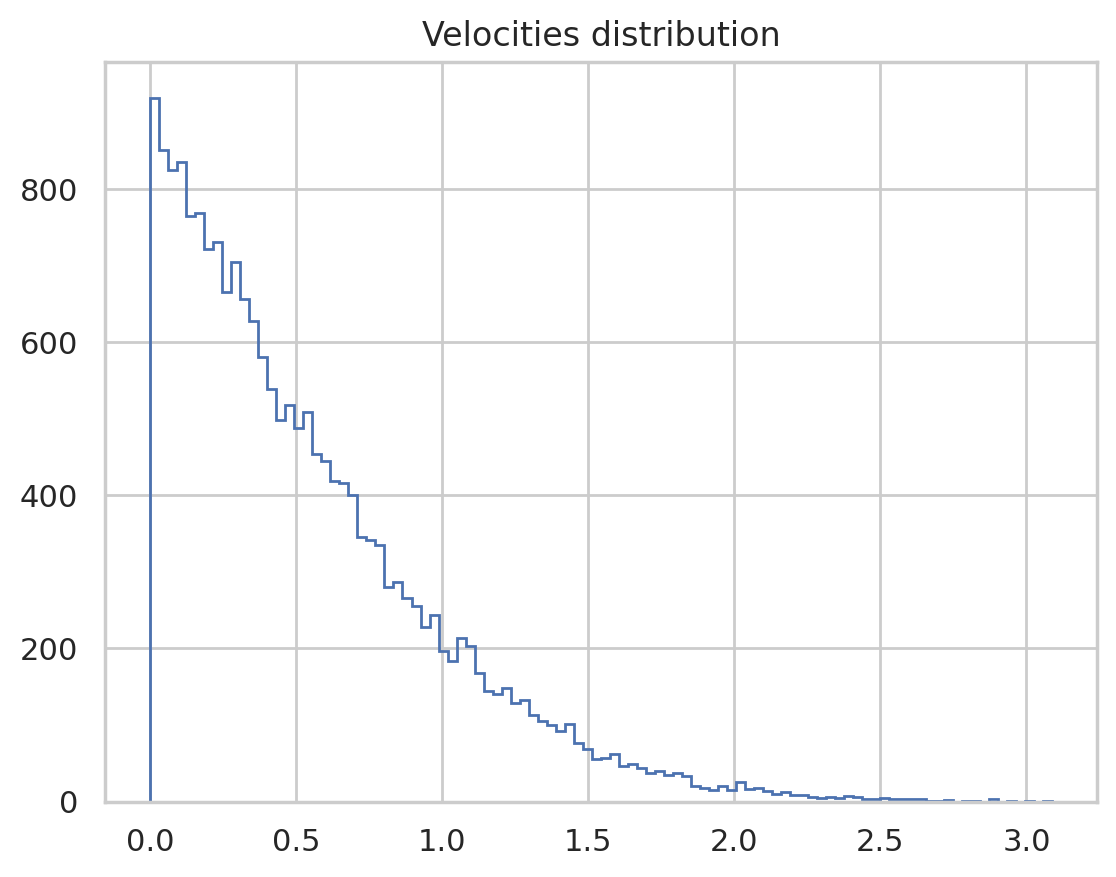

In [46]:
plt.hist(velocities, bins=100, histtype='step')
plt.title('Velocities distribution')

In [47]:
vel_theta_cdf = np.random.uniform(0, 1, N)
vel_theta = np.arccos(1 - 2 * vel_theta_cdf)

vel_phi = np.random.uniform(0, 2*np.pi, size=N)

V_X = velocities * np.sin(vel_theta) * np.cos(vel_phi)
V_Y = velocities * np.sin(vel_theta) * np.sin(vel_phi)
V_Z = velocities * np.cos(vel_theta)

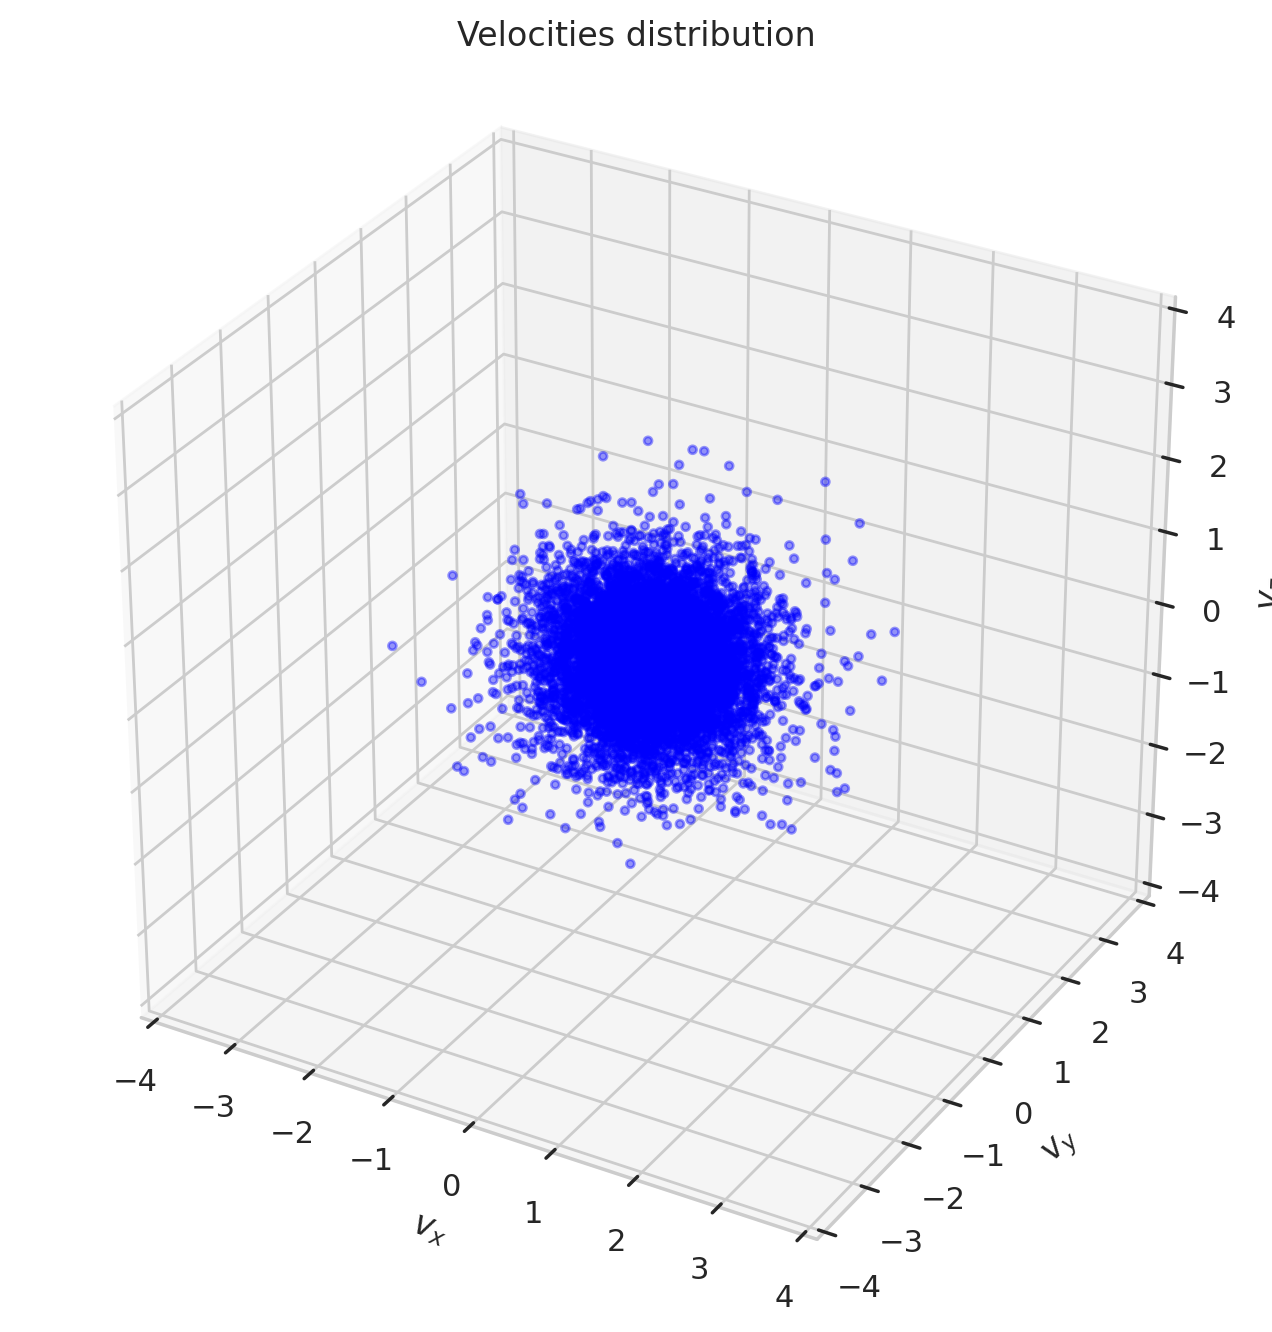

In [62]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(V_X, V_Y, V_Z, c = 'blue', s=8, alpha=0.4)
ax.set_aspect('equal')
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$v_z$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-4, 4)
ax.set_title("Velocities distribution")
plt.show();

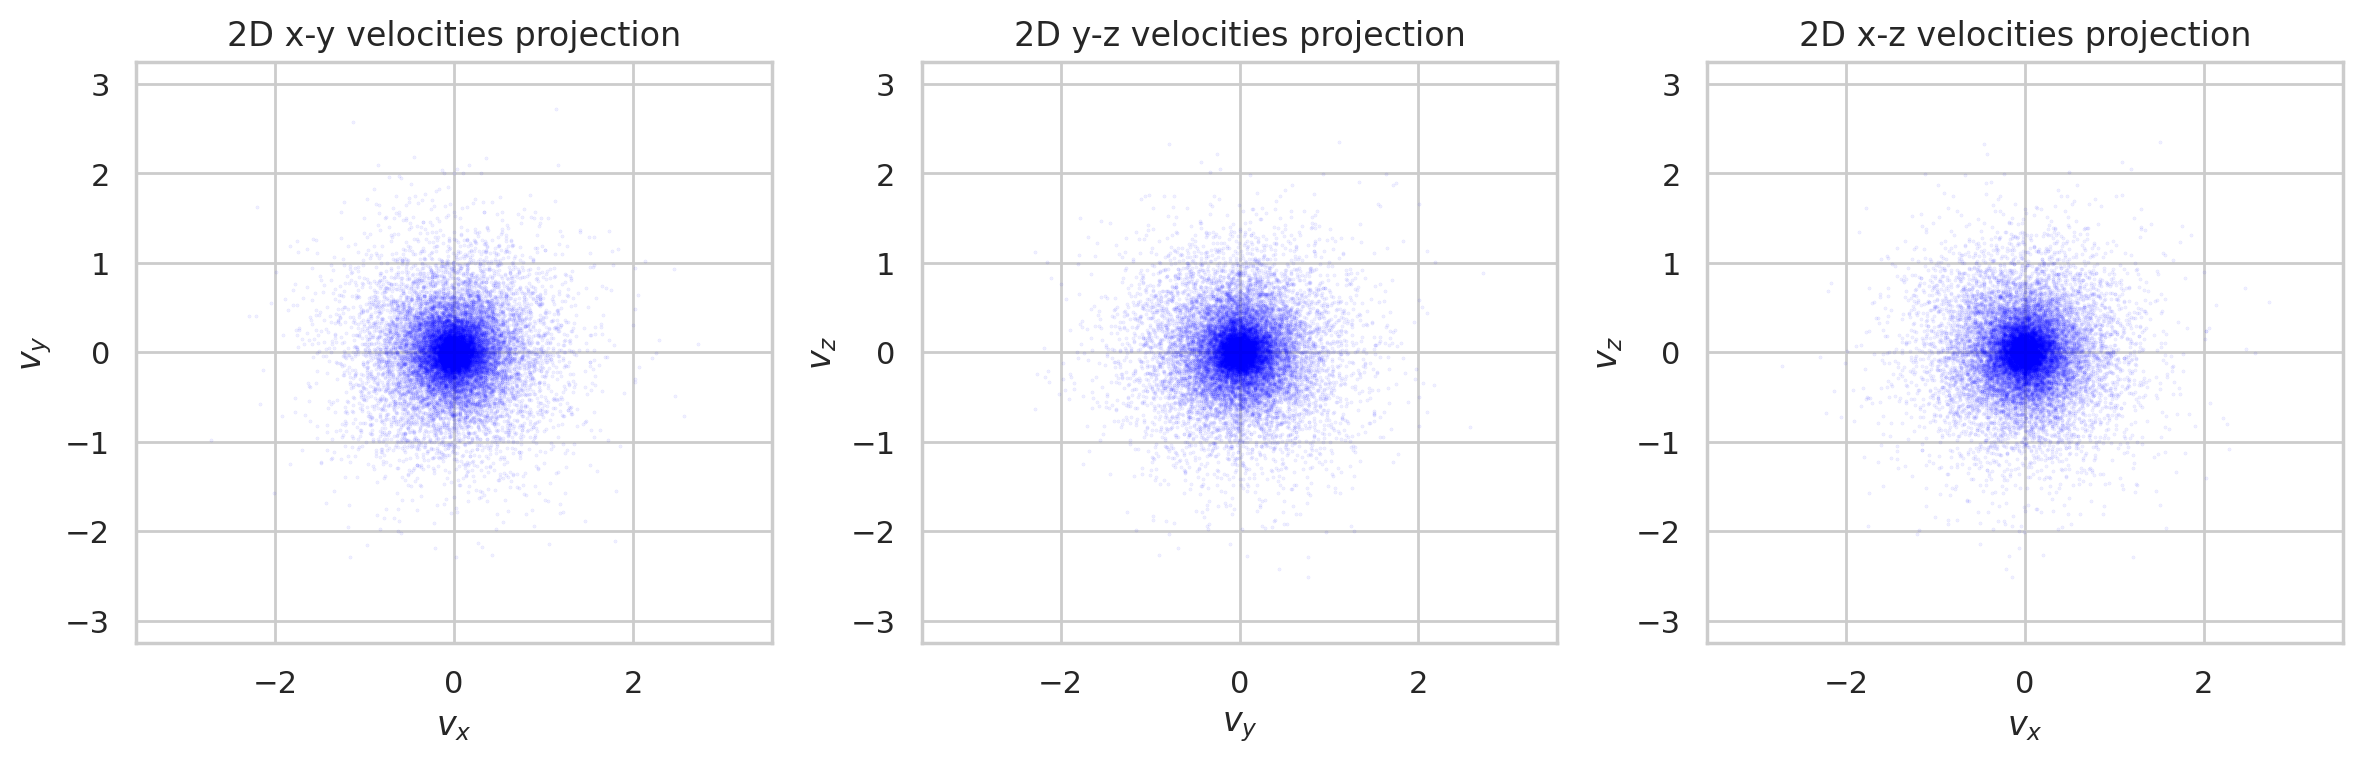

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#Projection on x-y plane
theta = np.linspace(0, 2 * np.pi, 150)

axes[0].scatter(V_X, V_Y, c='blue', s=0.1, alpha=0.1)
#axes[0].plot(a, c, c='red', label=r'$v_{esc}$', linewidth=4)
axes[0].axis('equal')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_xlabel(r'$v_x$')
axes[0].set_ylabel(r'$v_y$')
axes[0].set_title('2D x-y velocities projection')


# Projection on y-z plane
axes[1].scatter(V_Y, V_Z, c='blue', s=0.1, alpha=0.1)
axes[1].axis('equal')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_xlabel(r'$v_y$')
axes[1].set_ylabel(r'$v_z$')
axes[1].set_title('2D y-z velocities projection')



# Projection on x-z plane
axes[2].scatter(V_X, V_Z, c='blue', s=0.1, alpha=0.1)
axes[2].axis('equal')
axes[2].set_xlim(-4, 4)
axes[2].set_ylim(-4, 4)
axes[2].set_xlabel(r'$v_x$')
axes[2].set_ylabel(r'$v_z$')
axes[2].set_title('2D x-z velocities projection')


plt.tight_layout()
plt.show()

In [50]:
escape_vel = np.sqrt(- 2 * np.sort(Psi))

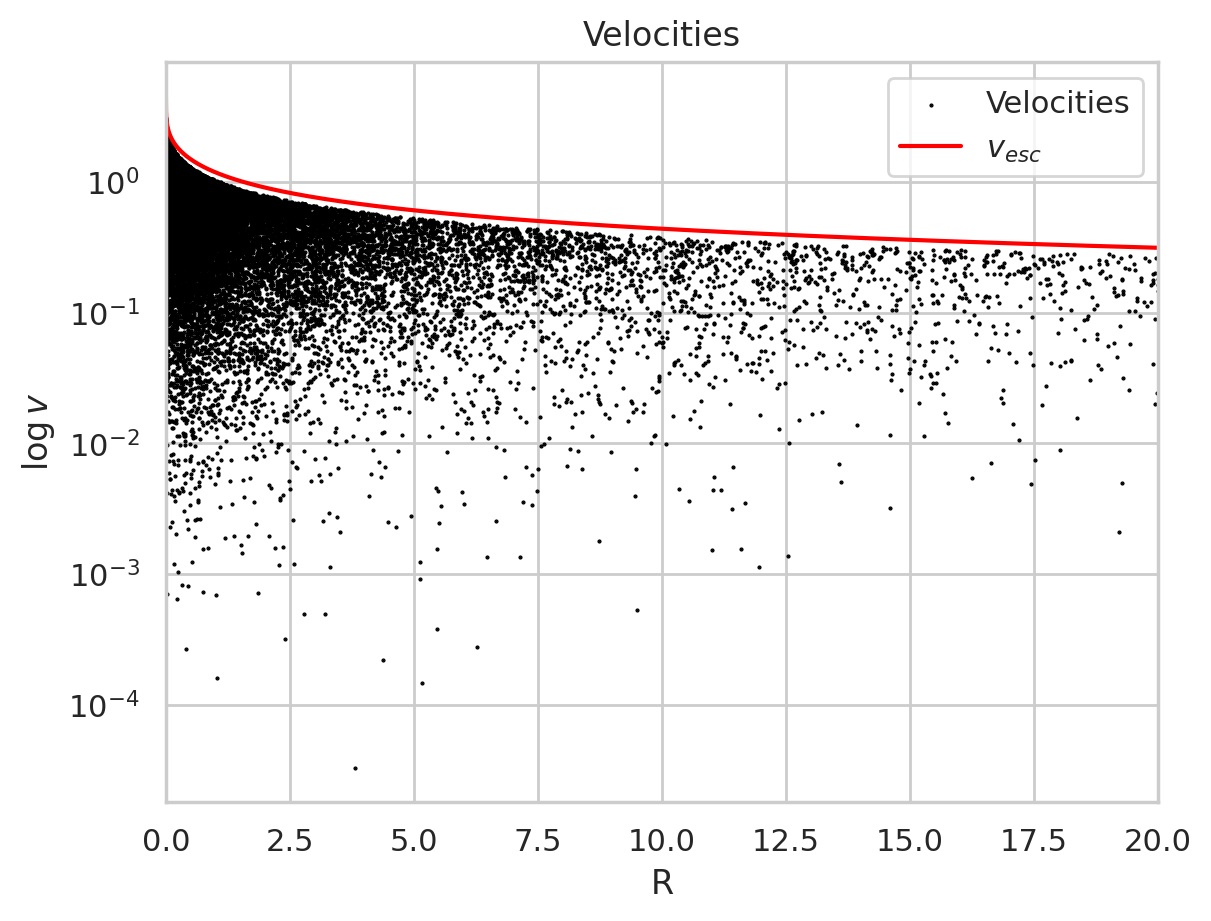

In [51]:
plt.scatter(Rays, velocities, marker='.', s=1, color='black', label='Velocities')
plt.plot(np.sort(Rays), escape_vel, color='red', label=r'$v_{esc}$')
plt.xlabel('R')
plt.ylabel(r'$\log{v}$')
plt.xlim(0, 20)
plt.yscale('log')
plt.title('Velocities')
plt.legend()

## Inserting the perturber



In [52]:
m_pert = M/30

# Posizione del perturber: all'interno del raggio scala
x_pert = 0.9
y_pert = 0
z_pert = 0

r_pert = np.sqrt(x_pert**2 + y_pert**2 + z_pert**2)

# Velocità del perturber: minore della velocità di fuga
pot_pert  = Jaffe_pot(r_pert, Rs, rho_0)
v_esc_pert = np.sqrt(- 2 * pot_pert)

v_pert = v_esc_pert/np.sqrt(2)
#v_pert = np.random.uniform(0, v_esc_pert)

vx_pert = 0
vy_pert = v_pert
vz_pert = 0

vy_pert

0.8644156418241291

In [53]:
# Quante particelle ho all'interno di r_pert?
provv = len([el for el in Rays if el < r_pert])

provv

9462

In [54]:
masses = np.ones(N) * m

In [55]:
masses = np.insert(masses, 0, m_pert)

X = np.insert(X, 0, x_pert)
Y = np.insert(Y, 0, y_pert)
Z = np.insert(Z, 0, z_pert)

V_X = np.insert(V_X, 0, vx_pert)
V_Y = np.insert(V_Y, 0, vy_pert)
V_Z = np.insert(V_Z, 0, vz_pert)


In [56]:
masses

array([3.33333333e-02, 5.00000000e-05, 5.00000000e-05, ...,
       5.00000000e-05, 5.00000000e-05, 5.00000000e-05])

In [57]:
masses.shape

(20001,)

## Building the file with initial conditions

In [58]:
Y.shape

(20001,)

In [59]:
# open the file
file = open(f'Jaffe_test_perturber_{N}.txt', 'w')

# write the file
file.write(f'{N+1}\n')
file.write('3\n') # dimensions
file.write('0\n')

for i in range(len(X)):
    file.write(f'{masses[i]}\n')

for i in range(len(X)):
    file.write(f'{X[i]} {Y[i]} {Z[i]}\n')
    
for i in range(len(X)):
    file.write(f'{V_X[i]} {V_Y[i]} {V_Z[i]}\n')

# close the file
file.close()

In [60]:
rho0 = M/(4 * np.pi * Rs**3)

T_dyn = np.sqrt(32 / (3 * np.pi * rho0))
print("Dynamical Time: ", T_dyn)

V = 4/3 * np.pi * Rs**3
epsilon = round(1/10 * (V/N)**(1/3), 4)
print("Epsilon: ", epsilon)

T_sim = np.round(5 * T_dyn)
print("Simulation time: ", T_sim)

input_file = f'../../Project/Jaffe_test_perturber_{N}.txt'
out_file = f'../../Project/Jaffe_{N}_out_perturber.txt'
logfile  = f'../../Project/Jaffe_log_perturber_{N}.txt'

dt = 1/30
theta = 0.2
t_out = 2*dt

Dynamical Time:  6.531972647421808
Epsilon:  0.0059
Simulation time:  33.0


In [61]:
print('./treecode in='+str(input_file)+' dtime='+ str(dt) + ' eps='+str(epsilon)+' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+  ' out='+str(out_file)+' >'+str(logfile))

./treecode in=../../Project/Jaffe_test_perturber_20000.txt dtime=0.03333333333333333 eps=0.0059 theta=0.2 tstop=33.0 dtout=0.06666666666666667 out=../../Project/Jaffe_20000_out_perturber.txt >../../Project/Jaffe_log_perturber_20000.txt
